# Team 12
Nidhin Pramod 202294678      
Rahul Raghunathan Nair - 202280100          
Yen-Ting Lin - 202259842                
Rahul Nurukurthi - 202270308            
Richaben Ankurkumar Patel - 202289339


#Introduction

This notebook includes a brief analysis of the solution/approach used to predict the popularity of a title from the Spotify dataset **(Regression problem)**. It describes in detail the data visualisation, processing, model building techniques. It also includes prediction results and the comparison and observation between the training and test data RMSEs. Finally, we have also included justification for the approach taken in this notebook with brief details about the trial and error phase with different approaches.

# Libraries and initializations

###File upload for colab

In [ ]:
#Colab library for files I/O
from google.colab import files

uploaded = files.upload()

In [ ]:
#Library for mathematical computation
import numpy as np 
import pandas as pd 

#Library for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px

%matplotlib inline

#Library for modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

#load both training and test datasets
df_train = pd.read_csv('CS98XRegressionTrain.csv')
df_test= pd.read_csv('CS98XRegressionTest.csv')

## Combine both datasets to form one single dataframe

We are combining the training and test datasets because there are certain genres and artists present in the test dataset that never appear in the training data.
This leads to inconsistency in the number of columns when these categorical labels are encoded using One Hot Encoding. Combining the datasets and 
transforming the whole dataset using the same One Hot encoder solves this problem.

In [ ]:
df = pd.concat(objs=[df_train, df_test], axis=0)

# Exploring data

This dataset has 15 columns with 16 null values in the 'top genre' column. It has 3 categorical columns 'title', 'top genre' and 'artist'.

In [ ]:
#Understanding the data
print(df.shape)
print(df.head(2))
# Check the number of null values in each column of dataset
for rec in df.columns:
    print(rec,df[rec].isna().sum())

(567, 15)
   Id             title           artist        top genre  year  bpm  nrgy  \
0   1      My Happiness   Connie Francis  adult standards  1996  107    31   
1   2  Unchained Melody  The Teddy Bears              NaN  2011  114    44   

   dnce  dB  live  val  dur  acous  spch   pop  
0    45  -8    13   28  150     75     3  44.0  
1    53  -8    13   47  139     49     3  37.0  
Id 0
title 0
artist 0
top genre 16
year 0
bpm 0
nrgy 0
dnce 0
dB 0
live 0
val 0
dur 0
acous 0
spch 0
pop 114


#Visualising the data 

Here the predictor column i.e 'pop' is ploted on the graph to see how it progresses throughout the dataset. This curve will again be ploted with the predictions to determine visually how accurate the model is.

In [ ]:
fig = px.line(df_train.drop(['Id'],axis=1), x= range(0,df_train.shape[0]), y = sorted(df_train['pop']),
             hover_name = "title",hover_data= ['artist', 'top genre'])
fig.update_layout(title= 'Popularity sorted', 
                  xaxis =dict(title='Song index'),
                  yaxis =dict(title='pop'))
fig.show()

## Correlation

By observing the correlation of every feature and its impact on the predictor column ('pop') we can infer the following:

1. **nrgy, dur and dB** are **correlated** to the predictor.    
2. **acous** is **inversly correlated** to the predictor.
3. **val** has the **least correlation** to the predictor.


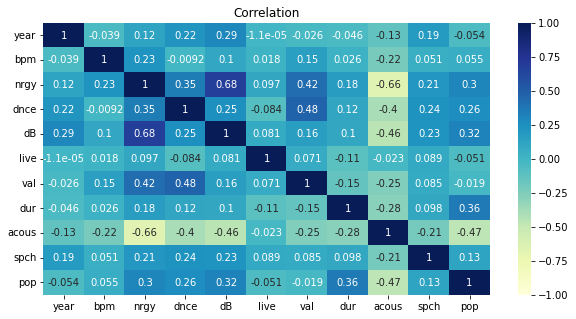

In [ ]:
plt.figure(figsize=(10,5))
heatmap = sns.heatmap(df_train.drop(['Id'],axis=1).corr(),cmap='YlGnBu', vmin=-1,vmax=1, annot=True)
heatmap.set_title('Correlation')
plt.show()

# Processing dataset

##Dealing with null data

To take care of the null values that were present only in the categorical column 'top genre', it has been replaced with 'Others'.

In [ ]:
df['top genre'] = df['top genre'].fillna('Others')

##Dropping features

We observed dropping Valence gave better results and it is clearly justified by the fact that it has the least correlation of -0.01 with Popularity (target). Title is always unique to each song and is not useful to predict unseen data, hence this column is dropped.

In [ ]:
X=df.drop(columns=['title','val','pop'])

## Checking for skewed data

Although the data in columns Live and Duration appear to be skewed, as we are dealing with a relatively small dataset, the skewed data does not impact the overall accuracy of the model.

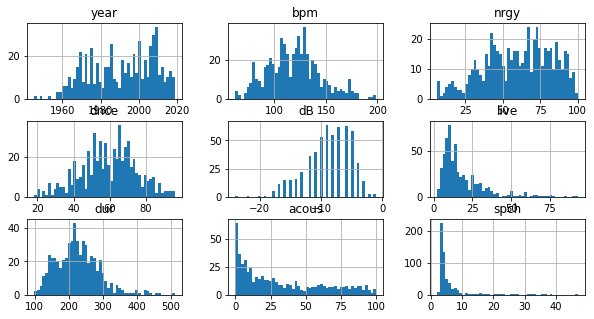

In [ ]:
X.drop(['Id'],axis=1).hist(bins=50, figsize=(10,5))
plt.show()

##Checking for outliers

Although the data in columns Live, Speechiness and Duration appear to have outliers, as we are dealing with a relatively small dataset, the outliers do not impact the overall accuracy of the model.

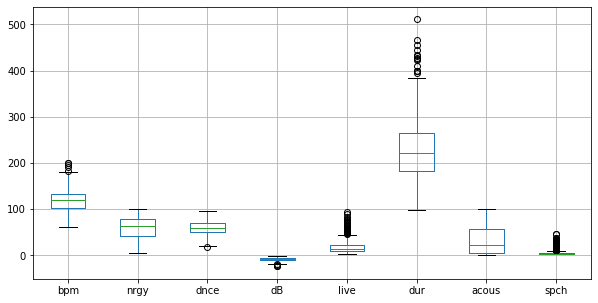

In [ ]:
X.drop(['Id','year'],axis=1).boxplot(figsize=(10,5))
plt.show()

##One hot encoding

The columns with categorical data 'top genre' and 'artist' are nominal. Therefore, these columns are transformed using One Hot Encoding.

In [ ]:
#One Hot encoding of Categorical values of Top Genre
genre_onehot = OneHotEncoder(sparse=False)
genre_onehotenc = genre_onehot.fit_transform(X[['top genre']])
genre_categories = genre_onehot.categories_
genre_data= pd.DataFrame(genre_onehotenc)
genre_data.columns = genre_categories[0]

#One hot encoding of artist data
artist_onehot = OneHotEncoder(sparse=False)
artist_onehotenc = artist_onehot.fit_transform(X[['artist']])
artist_categories = artist_onehot.categories_
artist_data= pd.DataFrame(artist_onehotenc)
artist_data.columns = artist_categories[0]

To reduce the curse of dimensionality, dropping the first column

In [ ]:
genre_data.drop(columns=['Others'], inplace = True)
artist_data.drop(columns=[' Wind & Fire'], inplace = True)

In [ ]:
#Retaining indexes which will be used later on to consolidate the dataset for training
genre_data.index = X.index
genre_data['Id1']=X ['Id']

#Retaining indexes which will be used later on to consolidate the dataset for training
artist_data.index = X.index
artist_data['Id2']=X ['Id']

##Checking the dataset for features to be scaled

In [ ]:
#Verifying the data to be scaled
print(X.iloc[:3,3:])

   year  bpm  nrgy  dnce  dB  live  dur  acous  spch
0  1996  107    31    45  -8    13  150     75     3
1  2011  114    44    53  -8    13  139     49     3
2  1979  105    36    63  -9    13  245     11     3


##Scaling dataset

After having tried Standard Scaler and MiMax Scaler, it was observed that using MinMax Scaler gave better results.

In [ ]:
X_to_scale = X.iloc[:,3:]
X_to_scale
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
X_scaled_all = pd.DataFrame(scaler_minmax.fit_transform(X_to_scale), columns = X_to_scale.columns)
X_scaled_all.head(3)

,year,bpm,nrgy,dnce,dB,live,dur,acous,spch
0,0.689189,0.328467,0.265957,0.346154,0.695652,0.120879,0.125908,0.75,0.022222
1,0.891892,0.379562,0.404255,0.448718,0.695652,0.120879,0.099274,0.49,0.022222
2,0.459459,0.313869,0.319149,0.576923,0.652174,0.120879,0.355932,0.11,0.022222


In [ ]:
#Retaining indexes which will be used later on to consolidate the dataset for training
X_scaled_all.index = X.index
X_scaled_all['Id']=X ['Id']

##Preparing dataset for modeling

Merging the scaled and One Hot Encoded columns into a main dataset before we train the model.

In [ ]:
#Merging genre and artist
genre_artist=pd.merge(genre_data,artist_data, left_on='Id1', right_on='Id2', how='left').drop('Id2', axis=1)
# genre_artist.head(3)

In [ ]:
#Merging all encoded values and scaled values together
X_scaled_1=pd.merge(X_scaled_all, genre_artist, left_on='Id', right_on='Id1', how='left').drop('Id1', axis=1)
# X_scaled_1.head(3)

Extracting training and testing data based on the orginal indexes of train and test datasets.

In [ ]:
X_train=X_scaled_1.iloc[0:453,:]
X_test=X_scaled_1.iloc[453:,:]
# print('Training data \n',X_train['Id'].describe()) #ID Min = 1 Max=453 (matches with the original train dataset IDs)
# print('Testing data \n',X_test['Id'].describe()) #ID Min = 454 Max=567  (matches with the original test dataset IDs)

In [ ]:
#Dropping ID column as we no longer need it
X_train.drop(columns=['Id'], inplace = True)
X_test.drop(columns=['Id'], inplace = True)

In [ ]:
#Selecting our target variable
Y = df['pop']
# Y.head(3)

In [ ]:
#Setting Y Train
Y_train = Y.iloc[0:453]
Y_train.isna().sum()
Y_train = Y_train.astype('int64')


In [ ]:
#Setting Y Test
Y_test = Y.iloc[453:]
# Y_test.isna().sum() #Null as we dont know values for this column

In [ ]:
#Reorder columns
cols_at_end = ['year']
X_train_adj = X_train[[c for c in X_train if c not in cols_at_end] 
        + [c for c in cols_at_end if c in X_train]]

In [ ]:
#Reorder columns
cols_at_end = ['year']
X_test_adj = X_test[[c for c in X_train if c not in cols_at_end] 
        + [c for c in cols_at_end if c in X_test]]

#Building the model

We have experimented with multiple regression models such as Linear Regression, Stochastic Gradient Regressor, SVM Regressor and Random Forest Regressor and their individual performances can be seen below along with the performance of using them in a voting regressor. Since there are many predictors that have complex non-linear relation with tha target, linear regression does not perform well. SImilarly, as the presence of outliers can impact the position of decision boundaries which results in a bad performance by the SVM models. Random Forest regressors outperform all of them as they are robust to outliers and noise and are good at modeling non-linear data with a mix of numerical and categorical variables.
In terms of the train-test split, due to the relatively small size of the dataset and the presence of several categorical features appearing sparsely, K-fold cross validation did not yield any improvement in performance in comparison with regular train-test split.

In [ ]:
from sklearn.ensemble import VotingRegressor
#splitting the train data 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_adj, Y_train, test_size=0.1, random_state=42)

r1 = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
r2 = RandomForestRegressor(n_estimators=30, random_state=1) #optimal value 40
r3 = SVR(kernel="poly", degree=2, C=200, epsilon=0.2, gamma="scale") #optimal value C=200, epsilon 0.4
model = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
model.fit(X_train_s,y_train_s)
pred_values_y = model.predict(X_test_s)
lin_msev_y = mean_squared_error(y_test_s, pred_values_y)
lin_rmsev_y = np.sqrt(lin_msev_y)
print(lin_rmsev_y)

r4 = LinearRegression()
for clf in (r1, r2, r3, r4,model):
    clf.fit(X_train_s, y_train_s)
    ypred = clf.predict(X_test_s)
    print(clf, np.sqrt(mean_squared_error(y_test_s, ypred)))

10.023741042482078
SGDRegressor(eta0=0.1, penalty=None) 11.326822453157236
RandomForestRegressor(n_estimators=30, random_state=1) 9.688048566360234
SVR(C=200, degree=2, epsilon=0.2, kernel='poly') 11.003130166257453
LinearRegression() 206362231519586.88
VotingRegressor(estimators=[('lr', SGDRegressor(eta0=0.1, penalty=None)),
                            ('rf',
                             RandomForestRegressor(n_estimators=30,
                                                   random_state=1)),
                            ('r3',
                             SVR(C=200, degree=2, epsilon=0.2, kernel='poly'))]) 9.966931707849312


We have also tried other ensembling techniques such as ADA Boost with base estimator as Random Forest Regressor and Stacking with several models that are theoretically distinct from each other. We got the best results using the stacking approach. This is because each of underlying models work very differently to make predictions and the final meta model is able to learn and combine the predictions of the base models to produce a final very accurate prediction in a range of 9.5 - 9.65.

In [ ]:
RFR=RandomForestRegressor(n_estimators=20, random_state=42) # 20 is optimal value
RegModel = AdaBoostRegressor(n_estimators=50, base_estimator=RFR ,learning_rate=1)

#Creating the model on Training Data
AB=RegModel.fit(X_train_s,y_train_s)
prediction=AB.predict(X_test_s)
ada_mse_y = mean_squared_error(y_test_s, prediction)
ada_rmse_y = np.sqrt(ada_mse_y)
print('RMSE:',ada_rmse_y)

RMSE: 9.584985994864006


The below model has been trained on the complete training dataset and is used to make predictions on the complete test dataset, the resulting predictions were uploaded to Kaggle.

4.0380934257816055


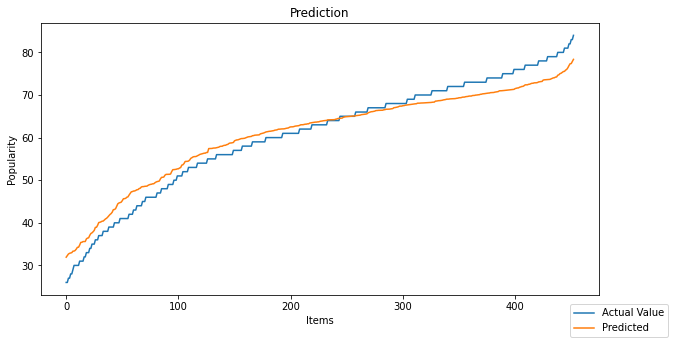

In [ ]:
#pred = stacked_model_diff.predict(X_test_adj)
estimators = [
    ('rf', RandomForestRegressor(n_estimators=40, random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('ksv',SVR(kernel="poly", degree=2, C=180, epsilon=0.4, gamma="scale")),
    ('lr',LinearRegression())
]
# Define the stacking ensemble model and the meta model which is LinearRegression in our case
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)
stacked_model.fit(X_train_adj, Y_train)
y_pred_stack = stacked_model.predict(X_train_adj)
print(np.sqrt(mean_squared_error(Y_train, y_pred_stack)))
pred_x_test_adj = stacked_model.predict(X_test_adj)

fig= plt.figure(figsize=(10,5))

plt.plot(range(0,X_train_adj.shape[0]),sorted(Y_train), label='Actual Value')
plt.plot(sorted(y_pred_stack), label='Predicted')

plt.title("Prediction")
plt.xlabel("Items")
plt.ylabel("Popularity")
fig.legend(loc='lower right')
plt.show()


In conclusion, for the regression model we stand 8th in the kaggle competition with a score of 7.05367. The RMSE of our model tested on the adjusted Train dataset however in the range of 4.03. This is because of the size of data used for training. The model is not trained on all possible combinations of the encoded values as well as other numerical values. The model is neither underfit nor overfit as observed from the graph above, which lets the model have an upper hand when it is introduced to new data points in any of the columns. 